In [1]:
## imports
from qiskit import *
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import quantum_info, IBMQ, Aer
#from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.visualization import plot_histogram, plot_state_qsphere, plot_bloch_multivector, plot_bloch_vector
import numpy as np
import seaborn as sns
from IPython.display import Image
import matplotlib.pyplot as plt

In [4]:
import qiskit.tools.jupyter
%qiskit_version_table 
# %qiskit_copyright

In [6]:
## setup simulator using IBM_id
#IBMQ.save_account("1c62e8a0d2b058d0e797db9c811bc34582df5553e25812301cd1518662c0ab68d2378ac6c197b65f8be944d04b7e7439f034e3926a44fa8088538b3d13782c1a", overwrite= True)
# provider = IBMQ.load_account()
# IBMQ.get_provider(hub='ibm-q-education', group='iit-madras-1', project='quantum-computin')
## setup required backends 
# lima = provider.get_backend('ibmq_lima')
# manila = provider.get_backend('ibmq_manila')
# qsm_simulator = Aer.get_backend('qasm_simulator')
# stv_simulator = Aer.get_backend('statevector_simulator')
aer = Aer.get_backend('aer_simulator')

In [17]:
def to_oracle(pattern, name= 'oracle'):
    """ convert a given pattern to an oracle
    pattern~ a numpy vector with binarry entries """
    l = len(pattern)
    qr = QuantumRegister(l, name='reg')
    a = AncillaRegister(1, name='ancilla')
    qc = QuantumCircuit(qr, a, name= name+str(pattern))
    for q in range(l):
        if(pattern[q]==0): qc.x(qr[q])
    qc.mcx(qr, a)
    for q in range(l):
        if(pattern[q]==0): qc.x(qr[q])
    #qc.barrier()
    return qc.to_gate()

def diffuser(l):
    qr = QuantumRegister(l, name='reg')
    a = AncillaRegister(1, name='ancilla')
    circuit = QuantumCircuit(qr, a, name= 'Diff.')
    
    circuit.h(qr)
    circuit.x(qr)
    
    circuit.x(a)
    circuit.h(a)
    circuit.mcx(qr ,a)
    circuit.h(a)
    circuit.x(a)

    circuit.x(qr)
    circuit.h(qr)
   


        
    return circuit.to_gate()

def grover_iterate(qc, oracles, diffuser, qreg_u, ancilla, steps):
    for step in range(steps):
        for oracle in oracles:
            qc.append(oracle, list(range(qc.num_qubits)) )
        qc.append(diffuser, list([q for q in qreg_u])+ list(ancilla) )
        qc.barrier()
    return qc


In [8]:
def run(given_state, patterns, grover_steps):
    dim_g = len(given_state)
    dim = len(patterns[0])
    dim_u = dim - dim_g

    # create oracles ~\
    oracles = []
    for pattern in patterns : oracles.append( to_oracle(pattern)) 
    # create diffuser ~\
    diff = diffuser(dim_u)
    # create circuit ~\
    qreg_g = QuantumRegister(dim_g, name= 'init')
    qreg_u = QuantumRegister(dim_u, name= 'unk')
    ancilla = AncillaRegister(1, name='ancilla')
    creg_g = ClassicalRegister(dim_g)
    creg_u = ClassicalRegister(dim_u)
    qc = QuantumCircuit(qreg_g, qreg_u, creg_g, creg_u, ancilla)
    # initiate 'init' register to 'given_state' ~\
    for q in range(len(qreg_g)):
        if(given_state[q] == 1): qc.x(qreg_g[q])
    # initiate 'unk' register to equal superpostion ~\
    qc.h(qreg_u)
    # run grover update steps ~\
    grover_iterate(qc, oracles, diff, qreg_u, ancilla,grover_steps)
   
    qc.measure(qreg_g, creg_g)
    qc.measure(qreg_u, creg_u)
    job = execute(qc, backend= aer, shots= 1024)
    plot_histogram(job.result().get_counts())
    
    return qc, job


In [15]:
p = [np.array([1,1,1,0]), np.array([1,1,0,1])]
qc, job = run(np.array([1,0,0,0]), p,2)

CircuitError: 'The number of control qubits must be in [1, num_qubits-1]'

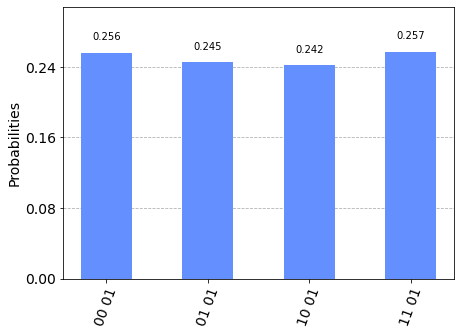

In [ ]:
plot_histogram(job.result().get_counts())

In [16]:
qc.decompose().draw(reverse_bits= True)
# qc.measure(qreg_g, qreg_u, creg)
# job = execute(qc, backend= aer, shots= 1024)
# plot_histogram(job.result().get_counts())

┌───┐     ┌───┐               ┌───┐           ░ »
ancilla: ──────────────────┤ X ├─────┤ X ├───────────────┤ X ├───────────░─»
          ┌─────────┐ ┌───┐└─┬─┘┌───┐└─┬─┘┌───┐┌───┐     └─┬─┘┌───┐┌───┐ ░ »
  unk_1: ─┤ U2(0,π) ├─┤ X ├──■──┤ X ├──■──┤ H ├┤ X ├───────■──┤ X ├┤ H ├─░─»
          ├─────────┤ └───┘  │  ├───┤  │  ├───┤├───┤┌───┐  │  ├───┤├───┤ ░ »
  unk_0: ─┤ U2(0,π) ├────────■──┤ X ├──■──┤ X ├┤ H ├┤ X ├──■──┤ X ├┤ H ├─░─»
          └─────────┘        │  └───┘  │  └───┘└───┘└───┘     └───┘└───┘ ░ »
 init_1: ────────────────────■─────────■─────────────────────────────────░─»
         ┌───────────┐       │         │                                 ░ »
 init_0: ┤ U3(π,0,π) ├───────■─────────■─────────────────────────────────░─»
         └───────────┘                                                   ░ »
   c5: 2/══════════════════════════════════════════════════════════════════»
                                                                           »
   c4: 2/══════════════════════════════════════════════════════════════════»
                                                                           »
«              ┌───┐     ┌───┐               ┌───┐           ░             
«ancilla: ─────┤ X ├─────┤ X ├───────────────┤ X ├───────────░─────────────
«         ┌───┐└─┬─┘┌───┐└─┬─┘┌───┐┌───┐     └─┬─┘┌───┐┌───┐ ░          ┌─┐
«  unk_1: ┤ X ├──■──┤ X ├──■──┤ H ├┤ X ├───────■──┤ X ├┤ H ├─░──────────┤M├
«         └───┘  │  ├───┤  │  ├───┤├───┤┌───┐  │  ├───┤├───┤ ░       ┌─┐└╥┘
«  unk_0: ───────■──┤ X ├──■──┤ X ├┤ H ├┤ X ├──■──┤ X ├┤ H ├─░───────┤M├─╫─
«                │  └───┘  │  └───┘└───┘└───┘     └───┘└───┘ ░    ┌─┐└╥┘ ║ 
« init_1: ───────■─────────■─────────────────────────────────░────┤M├─╫──╫─
«                │         │                                 ░ ┌─┐└╥┘ ║  ║ 
« init_0: ───────■─────────■─────────────────────────────────░─┤M├─╫──╫──╫─
«                                                            ░ └╥┘ ║  ║  ║ 
«   c5: 2/══════════════════════════════════════════════════════╬══╬══╩══╩═
«                                                               ║  ║  0  1 
«   c4: 2/══════════════════════════════════════════════════════╩══╩═══════
«                                                               0  1

In [5]:
def experiment(dim_g, dim_u, samples, grover_steps):
    dim = dim_g + dim_u
    patterns, oracles = [], []
    for j in range(samples):
        patterns.append(np.random.choice([0,1], size= dim))
    for j in range(samples):
        oracles.append(to_oracle(j))
    
    diff = diffuser(dim_u)

    qreg = QuantumRegister(dim, name='reg')
    creg = ClassicalRegister(dim, name='c')
    ancilla = AncillaRegister(1, name='ancilla')
    qc = QuantumCircuit(qreg, ancilla, creg)

    for j in range(dim_g):
        if(init_state[j] == 1): qc.x(qreg[j])
        

    qc.h(ancilla)
    qc.x(ancilla)
    qc.barrier()

    grover_iterate(qc, oracles, diff, grover_steps)
    qc.measure(qreg, creg)
    job = execute(qc, backend= aer)
    plot_histogram(job.result().counts())





In [10]:
p = np.array([1,0,1])
pqc = to_oracle(p)

In [42]:
qr = QuantumRegister(4)
qp = QuantumRegister(3)
anci = AncillaRegister(1)
qc = QuantumCircuit(qr, qp)

qc.h(qr)
qc.append(df, list([q for q in qp]))
qc.draw()

┌───┐   
q13_0: ──┤ H ├───
         ├───┤   
q13_1: ──┤ H ├───
         ├───┤   
q13_2: ──┤ H ├───
         ├───┤   
q13_3: ──┤ H ├───
       ┌─┴───┴──┐
q14_0: ┤0       ├
       │        │
q14_1: ┤1 Diff. ├
       │        │
q14_2: ┤2       ├
       └────────┘

In [43]:
list([q for q in qp]) + list(anci)

[Qubit(QuantumRegister(3, 'q14'), 0),
 Qubit(QuantumRegister(3, 'q14'), 1),
 Qubit(QuantumRegister(3, 'q14'), 2),
 AncillaQubit(AncillaRegister(1, 'a0'), 0)]